In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Wczytanie danych

In [3]:
df = pd.read_parquet('data/states_another_mod.parquet')
df

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
0,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
1,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.398438,5,3700,...,0,0,0,1,0,0,0,0,0,1
2,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.648438,5,3700,...,0,0,0,1,0,0,0,0,0,1
3,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.898438,5,3700,...,0,0,0,1,0,0,0,0,0,1
4,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,1.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186237 entries, 0 to 3186236
Columns: 108 entries, filename to bombsite_not_planted
dtypes: float64(17), int32(7), int64(68), object(6), uint8(10)
memory usage: 2.3+ GB


## Podział

In [5]:
df.columns

Index(['filename', 'mapName', 'ctBuyType', 'tBuyType', 'winningSide',
       'matchID', 'roundNum', 'seconds', 'ctAlivePlayers', 'ctEqVal',
       ...
       'de_ancient', 'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke',
       'de_overpass', 'de_vertigo', 'bombsite_A', 'bombsite_B',
       'bombsite_not_planted'],
      dtype='object', length=108)

In [6]:
def select_feat(prep_df):
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return prep_df[columns]

In [7]:
X = select_feat(df)
y = df['winningSideCT']
X.shape, y.shape

((3186237, 99), (3186237,))

In [8]:
y.value_counts()

1    1658611
0    1527626
Name: winningSideCT, dtype: int64

In [9]:
filtr = df.filename.str.startswith('BLAST-Premier-Spring-Final-2022')

In [10]:
X_train, X_test, y_train, y_test = X.loc[~filtr], X.loc[filtr], y[~filtr], y[filtr]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2886886, 99), (299351, 99), (2886886,), (299351,))

In [11]:
y_train.value_counts(normalize=True)

1    0.523845
0    0.476155
Name: winningSideCT, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.511179
1    0.488821
Name: winningSideCT, dtype: float64

In [13]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
]
)

In [14]:
parameters = {
    "logreg__C": Real(0.1, 100),
}

opt = BayesSearchCV(pipe,
                    search_spaces=parameters,
                    scoring="neg_log_loss",
                    n_iter=50,
                    n_jobs=3, 
                    cv=StratifiedKFold(n_splits=3),
                    verbose=1,
                    random_state=42)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('logreg',
                                         LogisticRegression(max_iter=1000))]),
              n_jobs=3, random_state=42, scoring='neg_log_loss',
              search_spaces={'logreg__C': Real(low=0.1, high=100, prior='uniform', transform='normalize')},
              verbose=1)

In [15]:
model_logreg = opt.best_estimator_
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
29,37.366784,3.805967,2.379506,0.954403,67.60131,{'logreg__C': 67.60130982256365},-0.447807,-0.457123,-0.461404,-0.455445,0.005676,50
36,50.878495,7.351967,3.704998,1.466456,37.745958,{'logreg__C': 37.74595760518518},-0.447809,-0.457122,-0.461402,-0.455444,0.005675,49
24,49.945107,6.730466,3.351512,0.986236,78.422248,{'logreg__C': 78.42224808686976},-0.447808,-0.457121,-0.461403,-0.455444,0.005675,48
42,49.195153,3.986278,3.515140,0.711339,27.868508,{'logreg__C': 27.86850846418363},-0.447807,-0.457121,-0.461403,-0.455444,0.005676,47
40,35.185661,2.606078,1.614604,0.042990,37.778357,{'logreg__C': 37.77835726254282},-0.447807,-0.457121,-0.461404,-0.455444,0.005676,46
18,43.306842,14.020380,6.197633,0.387307,78.280407,{'logreg__C': 78.28040722860747},-0.447808,-0.457121,-0.461402,-0.455444,0.005675,45
7,37.282287,2.588846,3.270821,1.622347,54.385966,{'logreg__C': 54.385966462262225},-0.447805,-0.457122,-0.461404,-0.455444,0.005677,44
39,50.793434,7.614652,6.047034,3.097144,97.454538,{'logreg__C': 97.454538015955},-0.447807,-0.457120,-0.461403,-0.455444,0.005676,43
5,51.505045,0.574344,2.383299,0.164913,73.429399,{'logreg__C': 73.42939899675828},-0.447808,-0.457120,-0.461402,-0.455443,0.005675,42
30,46.648379,2.285863,4.181871,0.531074,7.138188,{'logreg__C': 7.138188325664807},-0.447805,-0.457123,-0.461402,-0.455443,0.005676,41


In [16]:
X_train_scaled = model_logreg['scaler'].transform(X_train)
X_test_scaled = model_logreg['scaler'].transform(X_test)
explainer = shap.Explainer(model_logreg['logreg'], X_train_scaled, feature_names=X_train.columns.tolist())
shap_values = explainer(X_test_scaled)

Linear explainer: 299352it [00:11, 10343.69it/s]                                                                       


In [17]:
for i, name in enumerate(X_train.columns):
    shap_values.feature_names[i] = name

shap_values.data = X_test.values

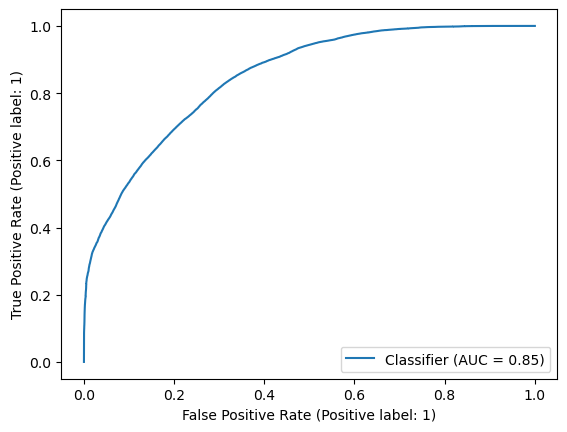

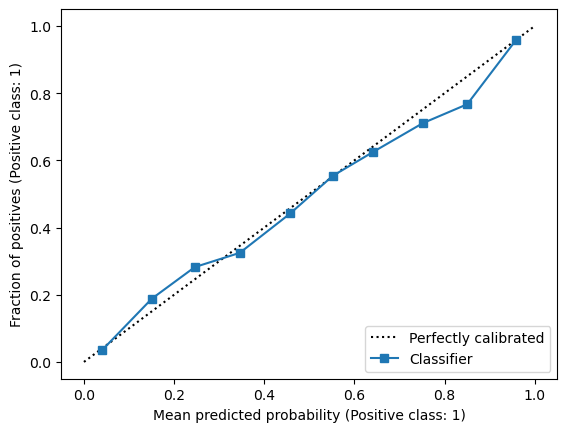

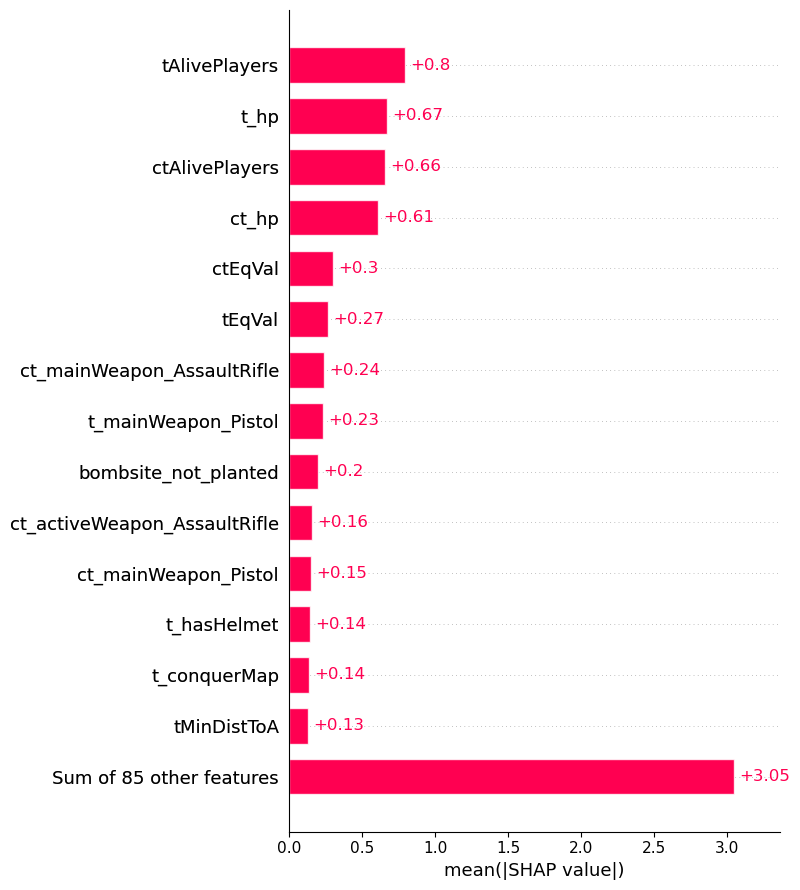

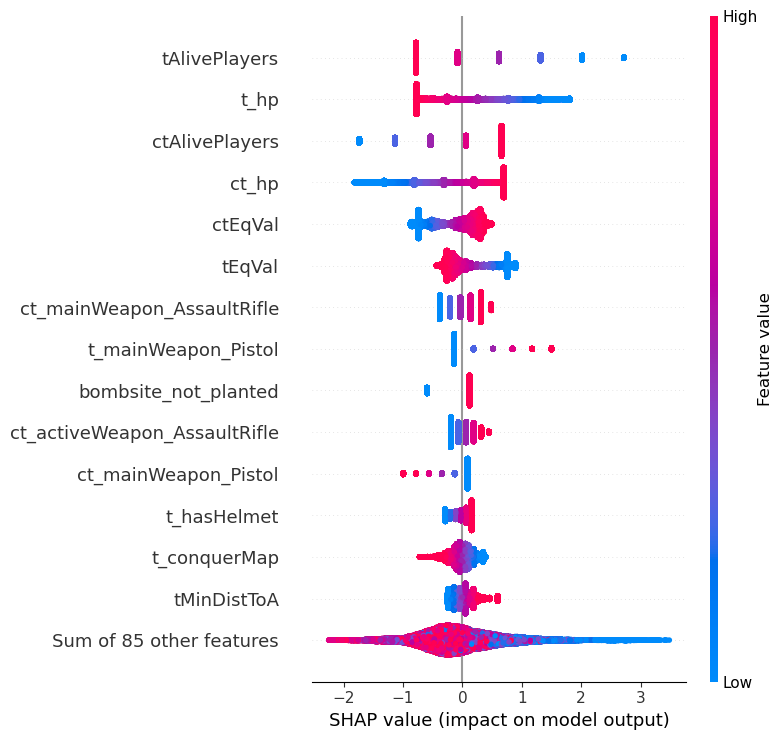

Failed to delete temporary folder: C:\Users\PC-KOM~1\AppData\Local\Temp\joblib_memmapping_folder_10708_088a3ea911504ae286add62113089ab9_0e392d5d7637403582a4e980b04a4b26


In [18]:
from sklearn.metrics import roc_auc_score
run_name = "Logistic Regression - All Variables Run"
additional_description = "Logistic Regression with Bayes Optimalization"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_logreg.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_logreg.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = X_train.columns.tolist()
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_logreg, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")